# Importing necessary libraries 

In [1]:
import os
import json
import torch
import string
import gensim
import gensim.downloader
from gensim.models import Word2Vec
import pandas as pd
from d2l import torch as d2l
from torch import nn
from tf_keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

2024-03-30 02:25:28.462103: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data preprocessing

## 1. Reading the json file

In [2]:
#Reading the json file
file_path = '/Users/admin/Library/CloudStorage/OneDrive-AshesiUniversity/Ashesi University/ashesi_year_4/machine_learning/d2l-en/pytorch/Final_Project/train.json.zip'
df = pd.read_json(file_path)
df

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...,...,...
6802,22678,EXAMPLE – JOURNEY MAP\n\nTHE CHALLENGE My w...,"[EXAMPLE, –, JOURNEY, MAP, \n\n, THE, CHALLENG...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,Why Mind Mapping?\n\nMind maps are graphical r...,"[Why, Mind, Mapping, ?, \n\n, Mind, maps, are,...","[True, True, False, False, False, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"Challenge\n\nSo, a few months back, I had chos...","[Challenge, \n\n, So, ,, a, few, months, back,...","[False, False, False, True, True, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,Brainstorming\n\nChallenge & Selection\n\nBrai...,"[Brainstorming, \n\n, Challenge, &, Selection,...","[False, False, True, True, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [3]:
# get relevant columns
# clean full_text and remove extra characters 
# create word index
# encode bio labels
# explode data to get tokens

## 2. Extracting relevant columns

In [4]:
data = df[['document', 'tokens', 'labels']]
data['tokens'][0]
len(data['tokens'][0])

753

## 3. Cleaning tokens columns in data set

In [5]:
def preprocess(tokens):
    lowercase_tokens = [token.lower() for token in tokens]
    return lowercase_tokens

In [6]:
data['processed_tokens'] = data['tokens'].apply(preprocess)
data = data[['document', 'processed_tokens', 'labels']]
data

/var/folders/h3/ngfp429s6d3d3kvbxfb1q9pm0000gn/T/ipykernel_13223/1502291209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['processed_tokens'] = data['tokens'].apply(preprocess)


,document,processed_tokens,labels
0,7,"[design, thinking, for, innovation, reflexion,...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,"[diego, estrada, \n\n, design, thinking, assig...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,"[reporting, process, \n\n, by, gilberto, gambo...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,"[design, thinking, for, innovation, \n\n, sind...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,"[assignment, :, , visualization, , reflecti...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...
6802,22678,"[example, –, journey, map, \n\n, the, challeng...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,"[why, mind, mapping, ?, \n\n, mind, maps, are,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"[challenge, \n\n, so, ,, a, few, months, back,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,"[brainstorming, \n\n, challenge, &, selection,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


## 4. Creating word index for processed_tokens examples in data

In [7]:
tokens = data['processed_tokens']

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)
word_index = tokenizer.word_index
word_index

{'the': 1,
 ' ': 2,
 '.': 3,
 'to': 4,
 ',': 5,
 'and': 6,
 'of': 7,
 '\n\n': 8,
 'a': 9,
 'in': 10,
 'i': 11,
 'we': 12,
 'that': 13,
 'for': 14,
 'is': 15,
 'with': 16,
 'it': 17,
 'this': 18,
 'was': 19,
 'as': 20,
 'our': 21,
 'on': 22,
 'be': 23,
 'their': 24,
 '\t\r \xa0': 25,
 '-': 26,
 'they': 27,
 'have': 28,
 'my': 29,
 'tool': 30,
 'are': 31,
 'from': 32,
 'what': 33,
 'were': 34,
 'them': 35,
 'not': 36,
 'by': 37,
 'or': 38,
 'an': 39,
 'can': 40,
 ':': 41,
 'more': 42,
 '\xa0': 43,
 'team': 44,
 'design': 45,
 'all': 46,
 ')': 47,
 'would': 48,
 'will': 49,
 'which': 50,
 'challenge': 51,
 'process': 52,
 'how': 53,
 'also': 54,
 'about': 55,
 'time': 56,
 'mind': 57,
 '(': 58,
 'had': 59,
 'people': 60,
 'learning': 61,
 'at': 62,
 'approach': 63,
 'one': 64,
 'use': 65,
 'new': 66,
 'so': 67,
 'thinking': 68,
 'but': 69,
 'different': 70,
 'visualization': 71,
 'you': 72,
 'work': 73,
 'us': 74,
 'launch': 75,
 'problem': 76,
 'ideas': 77,
 'could': 78,
 'each': 79,
 'a

In [9]:
len(word_index)

44390

## 5. Placing encoded tokens in data

In [10]:
encoded_tokens = tokenizer.texts_to_sequences(tokens)

In [11]:
data['encoded_tokens'] = encoded_tokens
data = data[['document', 'processed_tokens', 'encoded_tokens', 'labels']]
data

,document,processed_tokens,encoded_tokens,labels
0,7,"[design, thinking, for, innovation, reflexion,...","[45, 68, 14, 271, 8702, 26, 16418, 3564, 26, 1...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,"[diego, estrada, \n\n, design, thinking, assig...","[11538, 16424, 8, 45, 68, 624, 8, 71, 30, 8, 5...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,"[reporting, process, \n\n, by, gilberto, gambo...","[1723, 52, 8, 37, 24720, 24721, 8, 51, 8, 11, ...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,"[design, thinking, for, innovation, \n\n, sind...","[45, 68, 14, 271, 8, 24722, 24723, 8, 19273, 6...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,"[assignment, :, , visualization, , reflecti...","[624, 41, 251, 71, 43, 205, 251, 2360, 43, 37,...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...,...
6802,22678,"[example, –, journey, map, \n\n, the, challeng...","[257, 126, 304, 188, 8, 1, 51, 109, 29, 3938, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,"[why, mind, mapping, ?, \n\n, mind, maps, are,...","[247, 57, 84, 135, 8, 57, 515, 31, 1875, 3198,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"[challenge, \n\n, so, ,, a, few, months, back,...","[51, 8, 67, 5, 9, 311, 595, 354, 5, 11, 59, 99...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,"[brainstorming, \n\n, challenge, &, selection,...","[510, 8, 51, 134, 115, 8, 510, 15, 9, 113, 678...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


## 6. Exploding tokens and labels

In [12]:
len(data['encoded_tokens'][0])

753

In [13]:
len(data['labels'][0])

753

In [14]:
data = data.explode(['encoded_tokens', 'labels'])
print(data['encoded_tokens'].dtype)
data

object


,document,processed_tokens,encoded_tokens,labels
0,7,"[design, thinking, for, innovation, reflexion,...",45,O
0,7,"[design, thinking, for, innovation, reflexion,...",68,O
0,7,"[design, thinking, for, innovation, reflexion,...",14,O
0,7,"[design, thinking, for, innovation, reflexion,...",271,O
0,7,"[design, thinking, for, innovation, reflexion,...",8702,O
...,...,...,...,...
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",52,O
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",836,O
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",642,O
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",3,O


In [15]:
data['encoded_tokens'] = data['encoded_tokens'].astype(int)
print(data['encoded_tokens'].dtype)
data

int64


,document,processed_tokens,encoded_tokens,labels
0,7,"[design, thinking, for, innovation, reflexion,...",45,O
0,7,"[design, thinking, for, innovation, reflexion,...",68,O
0,7,"[design, thinking, for, innovation, reflexion,...",14,O
0,7,"[design, thinking, for, innovation, reflexion,...",271,O
0,7,"[design, thinking, for, innovation, reflexion,...",8702,O
...,...,...,...,...
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",52,O
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",836,O
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",642,O
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",3,O


## 6. Encoding BIO format labels

In [16]:
encoded_labels = pd.get_dummies(data['labels'])
encoded_labels 

,B-EMAIL,B-ID_NUM,B-NAME_STUDENT,B-PHONE_NUM,B-STREET_ADDRESS,B-URL_PERSONAL,B-USERNAME,I-ID_NUM,I-NAME_STUDENT,I-PHONE_NUM,I-STREET_ADDRESS,I-URL_PERSONAL,O
0,False,False,False,False,False,False,False,False,False,False,False,False,True
0,False,False,False,False,False,False,False,False,False,False,False,False,True
0,False,False,False,False,False,False,False,False,False,False,False,False,True
0,False,False,False,False,False,False,False,False,False,False,False,False,True
0,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6806,False,False,False,False,False,False,False,False,False,False,False,False,True
6806,False,False,False,False,False,False,False,False,False,False,False,False,True
6806,False,False,False,False,False,False,False,False,False,False,False,False,True
6806,False,False,False,False,False,False,False,False,False,False,False,False,True


In [17]:
encoded_labels_tensor = torch.tensor(encoded_labels.values, dtype=torch.int64)
categories = torch.argmax(encoded_labels_tensor, dim=1)
categories

tensor([12, 12, 12,  ..., 12, 12, 12])

In [18]:
data['encoded_labels'] = categories
data

,document,processed_tokens,encoded_tokens,labels,encoded_labels
0,7,"[design, thinking, for, innovation, reflexion,...",45,O,12
0,7,"[design, thinking, for, innovation, reflexion,...",68,O,12
0,7,"[design, thinking, for, innovation, reflexion,...",14,O,12
0,7,"[design, thinking, for, innovation, reflexion,...",271,O,12
0,7,"[design, thinking, for, innovation, reflexion,...",8702,O,12
...,...,...,...,...,...
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",52,O,12
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",836,O,12
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",642,O,12
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",3,O,12


## 7. Splitting data into training and test sets

In [19]:
num_rows_test = int(0.1 * len(data))
test_set = data.head(num_rows_test)
train_set = data.iloc[num_rows_test:]

In [20]:
train_set

,document,processed_tokens,encoded_tokens,labels,encoded_labels
614,8854,"[reflection, –, storytelling, \n\n, challenge,...",1,O,12
614,8854,"[reflection, –, storytelling, \n\n, challenge,...",574,O,12
614,8854,"[reflection, –, storytelling, \n\n, challenge,...",17222,O,12
614,8854,"[reflection, –, storytelling, \n\n, challenge,...",78,O,12
614,8854,"[reflection, –, storytelling, \n\n, challenge,...",154,O,12
...,...,...,...,...,...
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",52,O,12
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",836,O,12
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",642,O,12
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",3,O,12


In [21]:
test_set

,document,processed_tokens,encoded_tokens,labels,encoded_labels
0,7,"[design, thinking, for, innovation, reflexion,...",45,O,12
0,7,"[design, thinking, for, innovation, reflexion,...",68,O,12
0,7,"[design, thinking, for, innovation, reflexion,...",14,O,12
0,7,"[design, thinking, for, innovation, reflexion,...",271,O,12
0,7,"[design, thinking, for, innovation, reflexion,...",8702,O,12
...,...,...,...,...,...
614,8854,"[reflection, –, storytelling, \n\n, challenge,...",14,O,12
614,8854,"[reflection, –, storytelling, \n\n, challenge,...",1,O,12
614,8854,"[reflection, –, storytelling, \n\n, challenge,...",574,O,12
614,8854,"[reflection, –, storytelling, \n\n, challenge,...",10611,O,12


## 8. Defining feature and target tensors

In [22]:
features = train_set['encoded_tokens'].values
feature_tensor = torch.tensor(features, dtype=torch.int64)
feature_tensor = feature_tensor.view(-1, 1)
feature_tensor

tensor([[    1],
        [  574],
        [17222],
        ...,
        [  642],
        [    3],
        [    8]])

In [23]:
targets = train_set['encoded_labels'].values
target_tensor = torch.tensor(targets, dtype=torch.int64)
target_tensor

tensor([12, 12, 12,  ..., 12, 12, 12])

# Defining the Data Module

In [24]:
class PIIData(d2l.DataModule):
    "downloading and preprocessing data"
    def __init__(self, features, targets, batch_size):
        super().__init__()
        self.save_hyperparameters()
        n = features.shape[0]
        self.num_train = n//2
        self.num_val = n - self.num_train
        self.X = features
        self.y = targets

In [25]:
@d2l.add_to_class(d2l.DataModule) 
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors) 
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

In [26]:
@d2l.add_to_class(PIIData)
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [27]:
data = PIIData(feature_tensor, target_tensor, 32)

In [28]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape: ', y.shape)

X shape: torch.Size([32, 1]) 
y shape:  torch.Size([32])


# Defining the model

In [29]:
class BiLSTMModel(d2l.Classifier):
    """BiLSTM model for PII classification."""
    def __init__(self, vocab_size, embedding_dim, num_hiddens, num_outputs, lr, dropout=0.5):
        super().__init__()
        self.save_hyperparameters()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, num_hiddens, num_layers=2, bidirectional=True, dropout=dropout)
        self.fully_connected = nn.Linear(num_hiddens * 2, num_outputs)
        
    def forward(self, inputs):
        # print(torch.max(inputs))
        embeddings =  self.embeddings(inputs)
        embeddings = embeddings.permute(1, 0, 2)
        lstm_output, (hidden_state, cell_state) = self.lstm(embeddings)
        final_hidden_state = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1)
        predictions = self.fully_connected(final_hidden_state)
        probs = nn.functional.softmax(predictions, dim=-1)
        return probs

## 1. Download pretrained model or Load saved version

In [30]:
word2vec_path = 'glove-twitter-25.txt'

if os.path.exists(word2vec_path):
    # If the Word2Vec model already exists, load it
    word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=False)
else:
    # If the Word2Vec model doesn't exist, download and save it
    word2vec_model = gensim.downloader.load('glove-twitter-25')
    word2vec_model.save_word2vec_format(word2vec_path, binary=False)

In [31]:
# vocab = word2vec_model.index_to_key
# for word in vocab:
#     print(word)

In [32]:
# word2vec_model.most_similar('email')

## 2. Define model class

In [40]:
class PreTrained_BiLSTMModel(d2l.Classifier):
    """BiLSTM model that uses word2vec embeddings for PII classification."""
    def __init__(self, word2vec_model, num_hiddens, num_outputs, lr, dropout=0.5):
        super().__init__()
        self.save_hyperparameters()
        self.word_index = word_index
        self.index_to_word = {index: word for word, index in word_index.items()}
        self.word2vec_model = word2vec_model
        embedding_dim = self.word2vec_model.vector_size
        self.lstm = nn.LSTM(embedding_dim, num_hiddens, num_layers=2, bidirectional=True, dropout=dropout)
        self.fully_connected = nn.Linear(num_hiddens * 2, num_outputs)
        
    def forward(self, inputs):
        # print(torch.max(inputs))
        word_vectors =  self.get_word_vectors(inputs)
        lstm_output, (hidden_state, cell_state) = self.lstm(word_vectors)
        final_hidden_state = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1)
        predictions = self.fully_connected(final_hidden_state)
        probs = nn.functional.softmax(predictions, dim=-1)
        return probs

    def get_word_vectors(self, inputs):
        word_vectors = []
        # unk_token_vector = torch.zeros_like(next(iter(self.word2vec_model.values())))
        for token_index in inputs:
            token = self.index_to_word[token_index.item()]
            # print(token)
            if token in self.word2vec_model:
                word_vector = torch.tensor(self.word2vec_model[token])
            else:
                # Handle out-of-vocabulary tokens
                word_vector = torch.zeros_like(torch.tensor(self.word2vec_model.vectors[0]))
            word_vectors.append(word_vector)
        return torch.stack(word_vectors).unsqueeze(0)
        

# Training the model

In [35]:
# train_data = PIIData(features=feature_tensor, targets=target_tensor, batch_size=1024)
# model = BiLSTMModel(vocab_size=44400,embedding_dim=150, num_hiddens=13, num_outputs=13, lr=2)
# trainer = d2l.Trainer(max_epochs=10, gradient_clip_val=1, num_gpus=1)
# trainer.fit(model, train_data)

KeyboardInterrupt: 

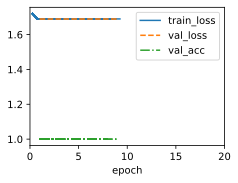

In [44]:
train_data = PIIData(features=feature_tensor, targets=target_tensor, batch_size=124)
model = PreTrained_BiLSTMModel(word2vec_model=word2vec_model, num_hiddens=13, num_outputs=13, lr=0.05)
trainer = d2l.Trainer(max_epochs=20, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, train_data)